## Visualize sidewalk polygons

In [1]:
import matplotlib.pyplot as plt

import upcp.utils.bgt_utils as bgt_utils
from sidewalk_filter import *

In [2]:
tilecode = '2386_9702'

# Create reader for BGT sidewalk part polygons.
bgt_road_file = '../datasets/bgt/bgt_voetpad_demo.csv'
bgt_sidewalk_reader = bgt_utils.BGTPolyReader(bgt_file=bgt_road_file)

sidewalk_polygons = bgt_sidewalk_reader.filter_tile(
                            tilecode, bgt_types=['voetpad'],
                            padding=0, offset=0,
                            merge=False)

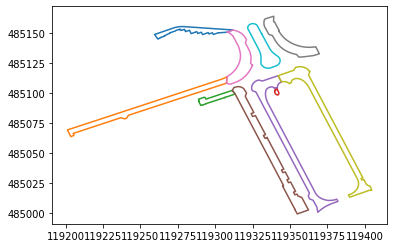

In [3]:
for poly in sidewalk_polygons:
    x,y = poly.exterior.xy
    plt.plot(x,y)

## 2D Visualization of obstacles

In [ ]:
import pandas as pd
from pathlib import Path
import ast
from shapely.geometry import Polygon

def get_obstacles():
    """
    Return a list of polygons representing each of the roads found in
    the area represented by the given CycloMedia tile-code.
    """
    obstacles = [ast.literal_eval(poly) for poly in df_obstacles.obstacle.values]
    poly_obstacles = [Polygon(rds)
                      for rds in obstacles]
    return poly_obstacles

bgt_obstacle_file = '../datasets/bgt/bgt_obstacle_demo.csv'
df_obstacles = pd.read_csv(Path(bgt_obstacle_file))
obstacles = get_obstacles()

In [ ]:
for obstacle in obstacles:
    x,y = obstacle.exterior.xy
    plt.plot(x,y)